In [1]:
#@title Copyright 2023 The Earth Engine Community Authors { display-mode: "form" }
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Species Distribution Modeling
Author: osgeokr

In this tutorial, the methodology of Species Distribution Modeling using Google Earth Engine will be introduced. A brief overview of Species Distribution Modeling  will be provided, followed by the process of predicting and analyzing the habitat of an endangered bird species known as the Fairy pitta (scientific name: *Pitta nympha*).

### Run me first

Run the following cell to initialize the API. The output will contain instructions on how to grant this notebook access to Earth Engine using your account.

In [2]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-dennis05')

## A brief overview of Species Distribution Modeling

Let's explore what species distribution models are, the advantages of using Google Earth Engine for their processing, the required data for the models, and how the workflow is structured.

### What is Species Distribution Modeling?

Species Distribution Modeling (SDM below) is the most common methodology used to estimate the actual or potential geographic distribution of a species. It involves characterizing the environmental conditions suitable for a particular species and then identifying where these suitable conditions are distributed geographically.

SDM has emerged as a crucial component of conservation planning in recent years, and various modeling techniques have been developed for this purpose. Implementing SDM in Google Earth Engine (GEE below) provides easy access to large-scale environmental data, along with powerful computing capabilities and support for machine learning algorithms, allowing for rapid modeling.

  > Note: Conservation biologist Dr. Ramiro D. Crego implemented SDM using the GEE JavaScript Code Editor and published his research findings [(Crego et al, 2022)](https://onlinelibrary.wiley.com/doi/10.1111/ddi.13491). The methodology of SDM introduced here has been translated and modified from the [JavaScript source code](https://smithsonian.github.io/SDMinGEE/) he shared into the Python language.

### Data Required for SDM

SDM typically utilizes the relationship between known species occurrence records and environmental variables to identify the conditions under which a population can sustain. In other words, two types of model input data are required:

1. Occurrence records of known species
1. Various environmental variables

These data are input into algorithms to identify environmental conditions associated with the presence of species.

### Workflow of SDM using GEE

The workflow for SDM using GEE is as follows:

1. Collection and preprocessing of species occurrence data
1. Definition of the Area of Interest
1. Addition of GEE environmental variables
1. Generation of pseudo-absence data
1. Model fitting and prediction
1. Variable importance and accuracy assessment

## Habitat Prediction and Analysis Using GEE

The [Fairy pitta (*Pitta nympha*)](https://datazone.birdlife.org/species/factsheet/22698684) will be used as a case study to demonstrate the application of GEE-based SDM. While this specific species has been selected for one example, researchers can apply the methodology to any target species of interest with slight modifications to the provided source code.

The Fairy pitta is a rare summer migrant and passage migrant in South Korea, whose distribution area is expanding due to recent climate warming on the Korean Peninsula. It is classified as a rare species, endangered wildlife of class II, Natural Monument No. 204, evaluated as Regionally Extinct (RE) in the National Red List, and Vulnerable (VU) according to the IUCN categories.

Conducting SDM for the conservation planning of the Fairy pitta appears to be quite valuable. Now, let's proceed with habitat prediction and analysis through GEE.

First, the Python libraries are imported.The `import` statement brings in the entire contents of a module, while the `from import` statement allows for the importation of specific objects from a module.

In [49]:
# Import libraries
import geemap

import geemap.colormaps as cm
import pandas as pd, geopandas as gpd
import numpy as np, matplotlib.pyplot as plt
import os, requests, math, random

from ipyleaflet import TileLayer
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Collection and Preprocessing of Species Occurrence Data

Now, let's collect occurrence data for the Fairy pitta. Even if you don't currently have access to occurrence data for the species of interest, you can obtain observational data about specific species through the GBIF API. The [GBIF API](https://techdocs.gbif.org/en/openapi/) is an interface that allows access to the species distribution data provided by GBIF, enabling users to search, filter, and download data, as well as acquire various information related to species.

In the code below, the `species_name` variable is assigned the scientific name of the species (e.g., *Pitta nympha* for Fairy pitta), and the `country_code` variable is assigned the country code (e.g., KR for South Korea). The `base_url` variable stores the address of the GBIF API. `params` is a dictionary containing parameters to be used in the API request:

* `scientificName`: Sets the scientific name of the species to be searched.
* `country`: Limits the search to a specific country.
* `hasCoordinate`: Ensures only data with coordinates (true) are searched.
* `basisOfRecord`: Chooses only records of human observation (`HUMAN_OBSERVATION`).
* `limit`: Sets the maximum number of results returned to 10000.

In [4]:
def get_gbif_species_data(species_name, country_code):
    """
    Retrieves observational data for a specific species using the GBIF API and returns it as a pandas DataFrame.

    Parameters:
    species_name (str): The scientific name of the species to query.
    country_code (str): The country code of the where the observation data will be queried.

    Returns:
    pd.DataFrame: A pandas DataFrame containing the observational data.
    """
    base_url = "https://api.gbif.org/v1/occurrence/search"
    params = {
        "scientificName": species_name,
        "country": country_code,
        "hasCoordinate": "true",
        "basisOfRecord": "HUMAN_OBSERVATION",
        "limit": 10000,
    }

    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()  # Raises an exception for a response error.
        data = response.json()
        occurrences = data.get("results", [])

        if occurrences:  # If data is present
            df = pd.json_normalize(occurrences)
            return df
        else:
            print("No data found for the given species and country code.")
            return pd.DataFrame()  # Returns an empty DataFrame
    except requests.RequestException as e:
        print(f"Request failed: {e}")
        return pd.DataFrame()  # Returns an empty DataFrame in case of an exception

Using the parameters set previously, we query the GBIF API for observational records of the Fairy pitta (*Pitta nympha*), and load the results into a DataFrame to check the first row. A DataFrame is a data structure for handling table-formatted data, consisting of rows and columns. If necessary, the DataFrame can be saved as a CSV file and read back in.

In [5]:
# Retrieve Fairy Pitta data
df = get_gbif_species_data("Pitta nympha", "KR")
"""
# Save DataFrame to CSV and read back in.
df.to_csv("pitta_nympha_data.csv", index=False)
df = pd.read_csv("pitta_nympha_data.csv")
"""
df.head(1)  # Display the first row of the DataFrame

,key,datasetKey,publishingOrgKey,installationKey,hostingOrganizationKey,publishingCountry,protocol,lastCrawled,lastParsed,crawlId,...,sex,preparations,nomenclaturalCode,fieldNotes,verbatimElevation,behavior,higherClassification,extensions.http://rs.tdwg.org/ac/terms/Multimedia,distanceFromCentroidInMeters,associatedTaxa
0,5167508573,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,28eb1a3f-1c15-4a95-931a-4af90ecb574d,US,DWC_ARCHIVE,2025-06-06T14:41:08.836+00:00,2025-06-07T01:31:07.690+00:00,548,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Next, we convert the DataFrame into a GeoDataFrame that includes a column for geographic information (`geometry`) and check the first row. A GeoDataFrame can be saved as a GeoPackage file (*.gpkg) and read back in.

In [6]:
# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.decimalLongitude,
                                df.decimalLatitude),
    crs="EPSG:4326"
)[["species", "year", "month", "geometry"]]
"""
# Convert GeoDataFrame to GeoPackage (requires pycrs module)
%pip install -U -q pycrs
gdf.to_file("pitta_nympha_data.gpkg", driver="GPKG")
gdf = gpd.read_file("pitta_nympha_data.gpkg")
"""
gdf.head(1)  # Display the first row of the GeoDataFrame

,species,year,month,geometry
0,Pitta nympha,2025,5,POINT (128.02186 35.66224)


This time, we have created a function to visualize the distribution of data by year and month from the GeoDataFrame and display it as a graph, which can then be saved as an image file. The use of a heatmap allows us to quickly grasp the frequency of species occurrence by year and month, providing an intuitive visualization of the temporal changes and patterns within the data. This allows for the identification of temporal patterns and seasonal variations in species occurrence data, as well as the rapid detection of outliers or quality issues within the data.

In [7]:
# Yearly and monthly data distribution heatmap
def plot_heatmap(gdf, h_size=8):

    statistics = gdf.groupby(["month", "year"]).size().unstack(fill_value=0)

    # Heatmap
    plt.figure(figsize=(h_size, h_size - 6))
    heatmap = plt.imshow(
        statistics.values, cmap="YlOrBr", origin="upper", aspect="auto"
    )

    # Display values above each pixel
    for i in range(len(statistics.index)):
        for j in range(len(statistics.columns)):
            plt.text(
                j, i, statistics.values[i, j], ha="center", va="center", color="black"
            )

    plt.colorbar(heatmap, label="Count")
    plt.title("Monthly Species Count by Year")
    plt.xlabel("Year")
    plt.ylabel("Month")
    plt.xticks(range(len(statistics.columns)), statistics.columns)
    plt.yticks(range(len(statistics.index)), statistics.index)
    plt.tight_layout()
    plt.savefig("heatmap_plot.png")
    plt.show()

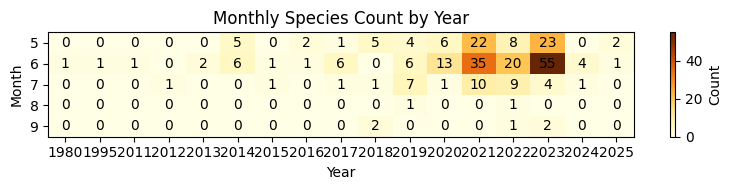

In [8]:
plot_heatmap(gdf)

The data from 1995 is very sparse, with significant gaps compared to other years, and the months of August and September also have limited samples and exhibit different seasonal characteristics compared to other periods. Excluding this data could contribute to improving the stability and predictive power of the model.

However, it's important to note that excluding data may enhance the model's generalization ability, but it could also lead to the loss of valuable information relevant to the research objectives. Therefore, such decisions should be made with careful consideration.

In [9]:
# Filtering data by year and month
filtered_gdf = gdf[
    (~gdf['year'].eq(1995)) &
    (~gdf['month'].between(8, 9))
]

Now, the filtered GeoDataFrame is converted into a Google Earth Engine object.

In [10]:
# Convert GeoDataFrame to Earth Engine object
data_raw = geemap.geopandas_to_ee(filtered_gdf)

Next, we will define the raster pixel size of the SDM results as 1km resolution.

In [11]:
# Spatial resolution setting (meters)
grain_size = 1000

When multiple occurrence points are present within the same 1km resolution raster pixel, there is a high likelihood that they share the same environmental conditions at the same geographic location. Using such data directly in the analysis can introduce bias into the results.

In other words, we need to limit the potential impact of geographic sampling bias. To achieve this, we will retain only one location within each 1km pixel and remove all others, allowing the model to more objectively reflect the environmental conditions.

In [12]:
def remove_duplicates(data, grain_size):
    # Select one occurrence record per pixel at the chosen spatial resolution
    random_raster = ee.Image.random().reproject("EPSG:4326", None, grain_size)
    rand_point_vals = random_raster.sampleRegions(
        collection=ee.FeatureCollection(data), geometries=True
    )
    return rand_point_vals.distinct("random")


data = remove_duplicates(data_raw, grain_size)

# Before selection and after selection
print("Original data size:", data_raw.size().getInfo())
print("Final data size:", data.size().getInfo())

Original data size: 266
Final data size: 151


The visualization comparing geographic sampling bias before preprocessing (in blue) and after preprocessing (in red) is shown below. To facilitate comparison, the map has been centered on the area with a high concentration of Fairy pitta occurrence coordinates in Hallasan National Park.

In [13]:
# Visualization of geographic sampling bias before (blue) and after (red) preprocessing
Map = geemap.Map(layout={"height": "400px", "width": "800px"})

# Add the random raster layer
random_raster = ee.Image.random().reproject("EPSG:4326", None, grain_size)
Map.addLayer(
    random_raster,
    {"min": 0, "max": 1, "palette": ["black", "white"], "opacity": 0.5},
    "Random Raster",
)

# Add the original data layer in blue
Map.addLayer(data_raw, {"color": "blue"}, "Original data")

# Add the final data layer in red
Map.addLayer(data, {"color": "red"}, "Final data")

# Set the center of the map to the coordinates
Map.setCenter(126.712, 33.516, 14)
Map

Map(center=[33.516, 126.712], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDat…

### Definition of the Area of Interest

Defining the Area of Interest (AOI below) refers to the term used by researchers to denote the geographical area they want to analyze. It has a similar meaning to the term Study Area.

In this context, we obtained the bounding box of the occurrence point layer geometry and created a 50-kilometer buffer around it (with a maximum tolerance of 1,000 meters) to define the AOI.

In [14]:
# Define the AOI
aoi = data.geometry().bounds().buffer(distance=50000, maxError=1000)

# Add the AOI to the map
outline = ee.Image().byte().paint(
    featureCollection=aoi, color=1, width=3)

Map.remove_layer("Random Raster")
Map.addLayer(outline, {'palette': 'FF0000'}, "AOI")
Map.centerObject(aoi, 6)
Map

Map(bottom=1682474.0, center=[35.60541125576072, 127.04873061439156], controls=(WidgetControl(options=['positi…

### Addition of GEE environmental variables

Now, let's add environmental variables to the analysis. GEE provides a wide range of datasets for environmental variables such as temperature, precipitation, elevation, land cover, and terrain. These datasets enable us to comprehensively analyze various factors that may influence the habitat preferences of the Fairy pitta.

The selection of GEE environmental variables in SDM should reflect the habitat preference characteristics of the species. To do this, prior research and literature review on the Fairy pitta's habitat preferences should be conducted. This tutorial primarily focuses on the workflow of SDM using GEE, so some in-depth details are omitted.

[**WorldClim V1 Bioclim**](https://developers.google.com/earth-engine/datasets/catalog/WORLDCLIM_V1_BIO): This dataset provides 19 bioclimatic variables derived from monthly temperature and precipitation data. It covers the period from 1960 to 1991 and has a resolution of 927.67 meters.

In [15]:
# WorldClim V1 Bioclim
bio = ee.Image("WORLDCLIM/V1/BIO")

[**NASA SRTM Digital Elevation 30m**](https://developers.google.com/earth-engine/datasets/catalog/USGS_SRTMGL1_003): This dataset contains digital elevation data from the Shuttle Radar Topography Mission (SRTM). The data was primarily collected around the year 2000 and is provided at a resolution of approximately 30 meters (1 arc-second). The following code calculates elevation, slope, aspect, and hillshade layers from the SRTM data.

In [16]:
# NASA SRTM Digital Elevation 30m
terrain = ee.Algorithms.Terrain(ee.Image("USGS/SRTMGL1_003"))

[**Global Forest Cover Change (GFCC) Tree Cover Multi-Year Global 30m**](https://developers.google.com/earth-engine/datasets/catalog/NASA_MEASURES_GFCC_TC_v3): The Vegetation Continuous Fields (VCF) dataset from Landsat estimates the proportion of vertically projected vegetation cover when the vegetation height is greater than 5 meters. This dataset is provided for four time periods centered around the years 2000, 2005, 2010, and 2015, with a resolution of 30 meters. Here, the median values from these four time periods are used.

In [17]:
# Global Forest Cover Change (GFCC) Tree Cover Multi-Year Global 30m
tcc = ee.ImageCollection("NASA/MEASURES/GFCC/TC/v3")
median_tcc = (
    tcc.filterDate("2000-01-01", "2015-12-31")
    .select(["tree_canopy_cover"], ["TCC"])
    .median()
)

`bio` (Bioclimatic variables), `terrain` (topography), and `median_tcc` (tree canopy cover) are combined into a single multiband image. The `elevation` band is selected from `terrain`, and a `watermask` is created for locations where `elevation` is greater than `0`. This masks regions below sea level (e.g. the ocean) and prepares the researcher to analyze various environmental factors for the AOI comprehensively.

In [18]:
# Combine bands into a multi-band image
predictors = bio.addBands(terrain).addBands(median_tcc)

# Create a water mask
watermask = terrain.select('elevation').gt(0)

# Mask out ocean pixels and clip to the area of interest
predictors = predictors.updateMask(watermask).clip(aoi)

When highly correlated predictor variables are included together in a model, multicollinearity issues can arise. Multicollinearity is a phenomenon that occurs when there are strong linear relationships among independent variables in a model, leading to instability in the estimation of the model's coefficients (weights). This instability can reduce the model's reliability and make predictions or interpretations for new data challenging. Therefore, we will consider multicollinearity and proceed with the process of selecting predictor variables.

First, we will generate 5,000 random points and then extract the predictor variable values of the single multiband image at those points.

In [19]:
# Generate 5,000 random points
data_cor = predictors.sample(scale=grain_size, numPixels=5000, geometries=True)

# Extract predictor variable values
pvals = predictors.sampleRegions(collection=data_cor, scale=grain_size)

We will convert the extracted predictor values for each point into a DataFrame and then check the first row.

In [20]:
# Converting predictor values from Earth Engine to a DataFrame
pvals_df = geemap.ee_to_df(pvals)
pvals_df.head(1)

,TCC,aspect,bio01,bio02,bio03,bio04,bio05,bio06,bio07,bio08,...,bio13,bio14,bio15,bio16,bio17,bio18,bio19,elevation,hillshade,slope
0,60.0,258,98,109,27,10278,281,-116,397,218,...,436,20,101,915,71,892,71,362,216,12


In [21]:
# Displaying the columns
columns = pvals_df.columns
print(columns)

Index(['TCC', 'aspect', 'bio01', 'bio02', 'bio03', 'bio04', 'bio05', 'bio06',
       'bio07', 'bio08', 'bio09', 'bio10', 'bio11', 'bio12', 'bio13', 'bio14',
       'bio15', 'bio16', 'bio17', 'bio18', 'bio19', 'elevation', 'hillshade',
       'slope'],
      dtype='object')


Calculating Spearman correlation coefficients between the given predictor variables and visualizing them in a heatmap.

In [22]:
def plot_correlation_heatmap(dataframe, h_size=10, show_labels=False):
    # Calculate Spearman correlation coefficients
    correlation_matrix = dataframe.corr(method="spearman")

    # Create a heatmap
    plt.figure(figsize=(h_size, h_size-2))
    plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')

    # Optionally display values on the heatmap
    if show_labels:
        for i in range(correlation_matrix.shape[0]):
            for j in range(correlation_matrix.shape[1]):
                plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}",
                         ha='center', va='center', color='white', fontsize=8)

    columns = dataframe.columns.tolist()
    plt.xticks(range(len(columns)), columns, rotation=90)
    plt.yticks(range(len(columns)), columns)
    plt.title("Variables Correlation Matrix")
    plt.colorbar(label="Spearman Correlation")
    plt.savefig('correlation_heatmap_plot.png')
    plt.show()

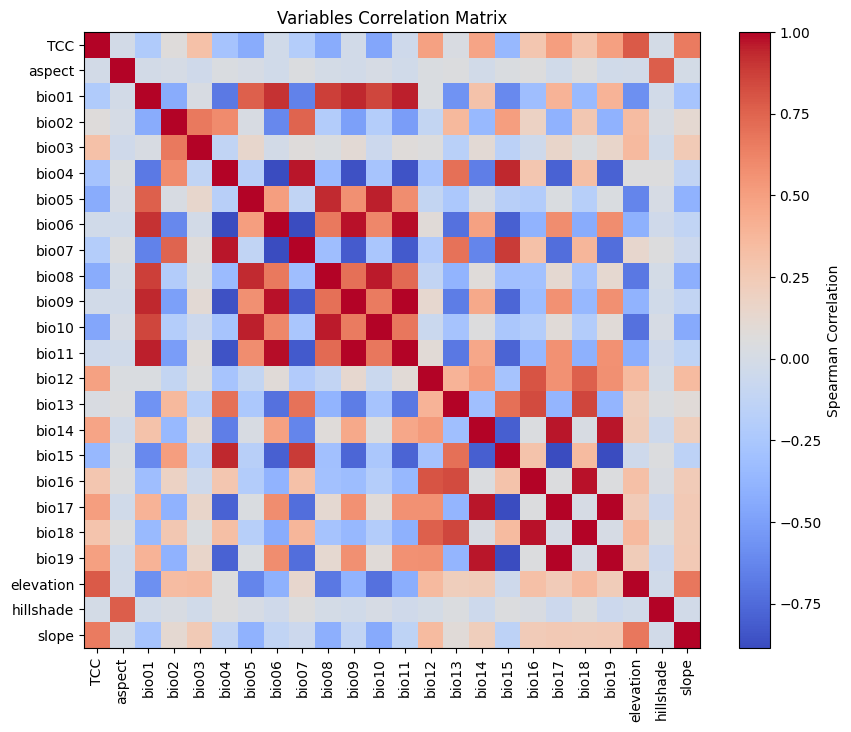

In [23]:
# Plot the correlation heatmap of variables
plot_correlation_heatmap(pvals_df)

Spearman correlation coefficient is useful for understanding the general associations among predictor variables but does not directly assess how multiple variables interact, specifically detecting multicollinearity.

The **Variance Inflation Factor (VIF below)** is a statistical metric used to evaluate multicollinearity and guide variable selection. It indicates the degree of linear relationship of each independent variable with the other independent variables, and high VIF values can be evidence of multicollinearity.

Typically, when VIF values exceed 5 or 10, it suggests that the variable has a strong correlation with other variables, potentially compromising the stability and interpretability of the model. In this tutorial, a criterion of VIF values less than 10 was used for variable selection. The following 6 variables were selected based on VIF.

In [24]:
# Filter variables based on Variance Inflation Factor (VIF)
def filter_variables_by_vif(dataframe, threshold=10):

    original_columns = dataframe.columns.tolist()
    remaining_columns = original_columns[:]

    while True:
        vif_data = dataframe[remaining_columns]
        vif_values = [
            variance_inflation_factor(vif_data.values, i)
            for i in range(vif_data.shape[1])
        ]

        max_vif_index = vif_values.index(max(vif_values))
        max_vif = max(vif_values)

        if max_vif < threshold:
            break

        print(f"Removing '{remaining_columns[max_vif_index]}' with VIF {max_vif:.2f}")

        del remaining_columns[max_vif_index]

    filtered_data = dataframe[remaining_columns]
    bands = filtered_data.columns.tolist()
    print("Bands:", bands)

    return filtered_data, bands

In [25]:
filtered_pvals_df, bands = filter_variables_by_vif(pvals_df)

Removing 'bio05' with VIF inf
Removing 'bio04' with VIF 191538.50
Removing 'bio10' with VIF 70131.66
Removing 'bio07' with VIF 46327.76
Removing 'bio17' with VIF 29347.60
Removing 'bio01' with VIF 9404.27
Removing 'bio16' with VIF 4086.88
Removing 'bio03' with VIF 2506.25
Removing 'bio18' with VIF 1843.00
Removing 'bio08' with VIF 1195.82
Removing 'bio06' with VIF 936.59
Removing 'bio12' with VIF 699.67
Removing 'bio15' with VIF 394.78
Removing 'bio19' with VIF 381.47
Removing 'hillshade' with VIF 132.86
Removing 'bio11' with VIF 49.93
Removing 'bio13' with VIF 37.81
Removing 'bio02' with VIF 12.82
Bands: ['TCC', 'aspect', 'bio09', 'bio14', 'elevation', 'slope']


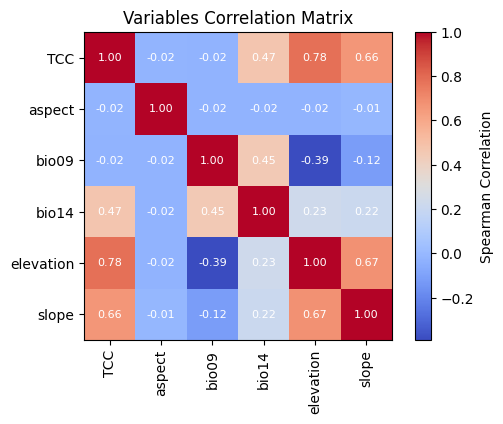

In [26]:
# Variable Selection Based on VIF
predictors = predictors.select(bands)

# Plot the correlation heatmap of variables
plot_correlation_heatmap(filtered_pvals_df, h_size=6, show_labels=True)

Next, let's visualize the 6 selected predictor variables on the map.
![Predictor Variables for Analysis](https://github.com/google/earthengine-community/blob/master/tutorials/species-distribution-modeling/predictor_variables.png?raw=1)

You can explore the available palettes for map visualization using the following code. For example, the `terrain` palette looks like this.
```
cm.plot_colormaps(width=8.0, height=0.2)
```

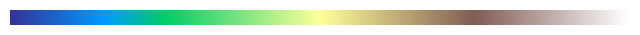

In [27]:
cm.plot_colormap('terrain', width=8.0, height=0.2, orientation='horizontal')

In [28]:
# Elevation layer
Map = geemap.Map(layout={'height':'400px', 'width':'800px'})

vis_params = {'bands':['elevation'], 'min': 0, 'max': 1800, 'palette': cm.palettes.terrain}
Map.addLayer(predictors, vis_params, 'elevation')
Map.add_colorbar(vis_params, label="Elevation (m)", orientation="vertical", layer_name="elevation")
Map.centerObject(aoi, 6)
Map

Map(center=[35.60541125576072, 127.04873061439156], controls=(WidgetControl(options=['position', 'transparent_…

In [29]:
# Calculate the minimum and maximum values for bio09
min_max_val = (
    predictors.select("bio09")
    .multiply(0.1)
    .reduceRegion(reducer=ee.Reducer.minMax(), scale=1000)
    .getInfo()
)

# bio09 (Mean temperature of driest quarter) layer
Map = geemap.Map(layout={"height": "400px", "width": "800px"})

vis_params = {
    "min": math.floor(min_max_val["bio09_min"]),
    "max": math.ceil(min_max_val["bio09_max"]),
    "palette": cm.palettes.hot,
}
Map.addLayer(predictors.select("bio09").multiply(0.1), vis_params, "bio09")
Map.add_colorbar(
    vis_params,
    label="Mean temperature of driest quarter (℃)",
    orientation="vertical",
    layer_name="bio09",
)
Map.centerObject(aoi, 6)
Map

Map(center=[35.60541125576072, 127.04873061439156], controls=(WidgetControl(options=['position', 'transparent_…

In [30]:
# Slope layer
Map = geemap.Map(layout={'height':'400px', 'width':'800px'})

vis_params = {'bands':['slope'], 'min': 0, 'max': 25, 'palette': cm.palettes.RdYlGn_r}
Map.addLayer(predictors, vis_params, 'slope')
Map.add_colorbar(vis_params, label="Slope", orientation="vertical", layer_name="slope")
Map.centerObject(aoi, 6)
Map

Map(center=[35.60541125576072, 127.04873061439156], controls=(WidgetControl(options=['position', 'transparent_…

In [31]:
# Aspect layer
Map = geemap.Map(layout={'height':'400px', 'width':'800px'})

vis_params = {'bands':['aspect'], 'min': 0, 'max': 360, 'palette': cm.palettes.rainbow}
Map.addLayer(predictors, vis_params, 'aspect')
Map.add_colorbar(vis_params, label="Aspect", orientation="vertical", layer_name="aspect")
Map.centerObject(aoi, 6)
Map

Map(center=[35.60541125576072, 127.04873061439156], controls=(WidgetControl(options=['position', 'transparent_…

In [32]:
# Calculate the minimum and maximum values for bio14
min_max_val = (
    predictors.select("bio14")
    .reduceRegion(reducer=ee.Reducer.minMax(), scale=1000)
    .getInfo()
)

# bio14 (Precipitation of driest month) layer
Map = geemap.Map(layout={"height": "400px", "width": "800px"})

vis_params = {
    "bands": ["bio14"],
    "min": math.floor(min_max_val["bio14_min"]),
    "max": math.ceil(min_max_val["bio14_max"]),
    "palette": cm.palettes.Blues,
}
Map.addLayer(predictors, vis_params, "bio14")
Map.add_colorbar(
    vis_params,
    label="Precipitation of driest month (mm)",
    orientation="vertical",
    layer_name="bio14",
)
Map.centerObject(aoi, 6)
Map

Map(center=[35.60541125576072, 127.04873061439156], controls=(WidgetControl(options=['position', 'transparent_…

In [33]:
# TCC layer
Map = geemap.Map(layout={"height": "400px", "width": "800px"})

vis_params = {
    "bands": ["TCC"],
    "min": 0,
    "max": 100,
    "palette": ["ffffff", "afce56", "5f9c00", "0e6a00", "003800"],
}
Map.addLayer(predictors, vis_params, "TCC")
Map.add_colorbar(
    vis_params, label="Tree Canopy Cover (%)", orientation="vertical", layer_name="TCC"
)
Map.centerObject(aoi, 6)
Map

Map(center=[35.60541125576072, 127.04873061439156], controls=(WidgetControl(options=['position', 'transparent_…

### Generation of pseudo-absence data

In the process of SDM, the selection of input data for a species is mainly approached using two methods:

1. **Presence-Background Method**: This method compares the locations where a particular species has been observed (presence) with other locations where the species has not been observed (background). Here, the background data does not necessarily mean areas where the species does not exist but rather is set up to reflect the overall environmental conditions of the study area. It is used to distinguish suitable environments where the species could exist from less suitable ones.

2. **Presence-Absence Method**: This method compares locations where the species has been observed (presence) with locations where it has definitively not been observed (absence). Here, absence data represents specific locations where the species is known not to exist. It does not reflect the overall environmental conditions of the study area but rather points to locations where the species is estimated not to exist.

In practice, it is often difficult to collect true absence data, so pseudo-absence data generated artificially is frequently used. However, it's important to acknowledge the limitations and potential errors of this method, as artificially generated pseudo-absence points may not accurately reflect true absence areas.

The choice between these two methods depends on data availability, research objectives, model accuracy and reliability, as well as time and resources. Here, we will use occurrence data collected from GBIF and artificially generated pseudo-absence data to model using the "Presence-Absence" method.

The generation of pseudo-absence data will be done through the "environmental profiling approach", and the specific steps are as follows:

1. Environmental Classification Using k-means Clustering: The k-means clustering algorithm, based on Euclidean distance, will be used to divide the pixels within the study area into two clusters. One cluster will represent areas with similar environmental characteristics to randomly selected 100 presence locations, while the other cluster will represent areas with different characteristics.

2. Generation of Pseudo-Absence Data within Dissimilar Clusters: Within the second cluster identified in the first step (which has different environmental characteristics from the presence data), randomly generated pseudo-absence points will be created. These pseudo-absence points will represent locations where the species is not expected to exist.

In [34]:
# Randomly select 100 locations for occurrence
pvals = predictors.sampleRegions(
    collection=data.randomColumn().sort('random').limit(100),
    properties=[],
    scale=grain_size
)

# Perform k-means clustering
clusterer = ee.Clusterer.wekaKMeans(
    nClusters=2,
    distanceFunction="Euclidean"
).train(pvals)

cl_result = predictors.cluster(clusterer)

# Get cluster ID for locations similar to occurrence
cl_id = cl_result.sampleRegions(
    collection=data.randomColumn().sort('random').limit(200),
    properties=[],
    scale=grain_size
)

# Define non-occurrence areas in dissimilar clusters
cl_id = ee.FeatureCollection(cl_id).reduceColumns(ee.Reducer.mode(),['cluster'])
cl_id = ee.Number(cl_id.get('mode')).subtract(1).abs()
cl_mask = cl_result.select(['cluster']).eq(cl_id)

In [35]:
# Presence location mask
presence_mask = data.reduceToImage(properties=['random'],
reducer=ee.Reducer.first()
).reproject('EPSG:4326', None,
            grain_size).mask().neq(1).selfMask()

# Masking presence locations in non-occurrence areas and clipping to AOI
area_for_pa = presence_mask.updateMask(cl_mask).clip(aoi)

# Area for Pseudo-absence
Map = geemap.Map(layout={'height':'400px', 'width':'800px'})
Map.addLayer(area_for_pa, {'palette': 'black'}, 'AreaForPA')
Map.centerObject(aoi, 6)
Map

Map(center=[35.60541125576072, 127.04873061439156], controls=(WidgetControl(options=['position', 'transparent_…

### Model fitting and prediction

We will now divide the data into training data and test data. The training data will be used to find the optimal parameters by training the model, while the test data will be used to evaluate the model trained beforehand. An important concept to consider in this context is spatial autocorrelation.

**Spatial autocorrelation** is an essential element in SDM, associated with Tobler's law. It embodies the concept that "everything is related to everything else, but near things are more related than distant things". Spatial autocorrelation represents the significant relationship between the location of species and environmental variables. However, if spatial autocorrelation exists between the training and test data, the independence between the two data sets can be compromised. This significantly impacts the evaluation of the model's generalization ability.

One method to address this issue is the spatial block cross-validation technique, which involves dividing the data into training and testing datasets. This technique involves dividing the data into multiple blocks, using each block independently as training and test datasets to reduce the impact of spatial autocorrelation. This enhances the independence between datasets, allowing for a more accurate evaluation of the model's generalization ability.

The specific procedure is as follows:
1. Creation of spatial blocks: Divide the entire dataset into spatial blocks of equal size (e.g., 50x50 km).
2. Assignment of training and testing sets: Each spatial block is randomly assigned to either the training set (70%) or the test set (30%). This prevents the model from overfitting to data from specific areas and aims to achieve more generalized results.
3. Iterative cross-validation: The entire process is repeated n times (e.g., 10 times). In each iteration, the blocks are randomly divided into training and test sets again, which is intended to improve the model's stability and reliability.
4. Generation of pseudo-absence data: In each iteration, pseudo-absence data are randomly generated to evaluate the model's performance.

In [36]:
Scale = 50000
grid = watermask.reduceRegions(
    collection=aoi.coveringGrid(scale=Scale, proj='EPSG:4326'),
    reducer=ee.Reducer.mean()).filter(ee.Filter.neq('mean', None))

Map = geemap.Map(layout={'height':'400px', 'width':'800px'})
Map.addLayer(grid, {}, "Grid for spatial block cross validation")
Map.addLayer(outline, {'palette': 'FF0000'}, "Study Area")
Map.centerObject(aoi, 6)
Map

Map(center=[35.60541125576072, 127.04873061439156], controls=(WidgetControl(options=['position', 'transparent_…

Now we can fit the model. Fitting a model involves understanding the patterns in the data and adjusting the model's parameters (weights and biases) accordingly. This process enables the model to make more accurate predictions when presented with new data. For this purpose, we have defined a function called SDM() to fit the model.

We will use the **Random Forest** algorithm.

In [37]:
def sdm(x):
    seed = ee.Number(x)

    # Random block division for training and validation
    rand_blk = ee.FeatureCollection(grid).randomColumn(seed=seed).sort("random")
    training_grid = rand_blk.filter(ee.Filter.lt("random", split))  # Grid for training
    testing_grid = rand_blk.filter(ee.Filter.gte("random", split))  # Grid for testing

    # Presence points
    presence_points = ee.FeatureCollection(data)
    presence_points = presence_points.map(lambda feature: feature.set("PresAbs", 1))
    tr_presence_points = presence_points.filter(
        ee.Filter.bounds(training_grid)
    )  # Presence points for training
    te_presence_points = presence_points.filter(
        ee.Filter.bounds(testing_grid)
    )  # Presence points for testing

    # Pseudo-absence points for training
    tr_pseudo_abs_points = area_for_pa.sample(
        region=training_grid,
        scale=grain_size,
        numPixels=tr_presence_points.size().add(300),
        seed=seed,
        geometries=True,
    )
    # Same number of pseudo-absence points as presence points for training
    tr_pseudo_abs_points = (
        tr_pseudo_abs_points.randomColumn()
        .sort("random")
        .limit(ee.Number(tr_presence_points.size()))
    )
    tr_pseudo_abs_points = tr_pseudo_abs_points.map(lambda feature: feature.set("PresAbs", 0))

    te_pseudo_abs_points = area_for_pa.sample(
        region=testing_grid,
        scale=grain_size,
        numPixels=te_presence_points.size().add(100),
        seed=seed,
        geometries=True,
    )
    # Same number of pseudo-absence points as presence points for testing
    te_pseudo_abs_points = (
        te_pseudo_abs_points.randomColumn()
        .sort("random")
        .limit(ee.Number(te_presence_points.size()))
    )
    te_pseudo_abs_points = te_pseudo_abs_points.map(lambda feature: feature.set("PresAbs", 0))

    # Merge training and pseudo-absence points
    training_partition = tr_presence_points.merge(tr_pseudo_abs_points)
    testing_partition = te_presence_points.merge(te_pseudo_abs_points)

    # Extract predictor variable values at training points
    train_pvals = predictors.sampleRegions(
        collection=training_partition,
        properties=["PresAbs"],
        scale=grain_size,
        geometries=True,
    )

    # Random Forest classifier
    classifier = ee.Classifier.smileRandomForest(
        numberOfTrees=500,
        variablesPerSplit=None,
        minLeafPopulation=10,
        bagFraction=0.5,
        maxNodes=None,
        seed=seed,
    )
    # Presence probability: Habitat suitability map
    classifier_pr = classifier.setOutputMode("PROBABILITY").train(
        train_pvals, "PresAbs", bands
    )
    classified_img_pr = predictors.select(bands).classify(classifier_pr)

    # Binary presence/absence map: Potential distribution map
    classifier_bin = classifier.setOutputMode("CLASSIFICATION").train(
        train_pvals, "PresAbs", bands
    )
    classified_img_bin = predictors.select(bands).classify(classifier_bin)

    return [
        classified_img_pr,
        classified_img_bin,
        training_partition,
        testing_partition,
    ], classifier_pr

Spatial blocks are divided into 70% for model training and 30% for model testing, respectively. Pseudo-absence data are randomly generated within each training and testing set in every iteration. As a result, each execution yields different sets of presence and pseudo-absence data for model training and testing.

In [38]:
split = 0.7
numiter = 10

# Random Seed
runif = lambda length: [random.randint(1, 1000) for _ in range(length)]
items = runif(numiter)

# Fixed seed
# items = [287, 288, 553, 226, 151, 255, 902, 267, 419, 538]

In [39]:
results_list = [] # Initialize SDM results list
importances_list = [] # Initialize variable importance list

for item in items:
    result, trained = sdm(item)
    # Accumulate SDM results into the list
    results_list.extend(result)

    # Accumulate variable importance into the list
    importance = ee.Dictionary(trained.explain()).get('importance')
    importances_list.extend(importance.getInfo().items())

# Flatten the SDM results list
results = ee.List(results_list).flatten()

Now we can visualize the **habitat suitability map** and **potential distribution map** for the Fairy pitta. In this case, the habitat suitability map is created by using the `mean()` function to calculate the average for each pixel location across all images, and the potential distribution map is generated by using the `mode()` function to determine the most frequently occurring value at each pixel location across all images.

![SDM results](https://github.com/google/earthengine-community/blob/master/tutorials/species-distribution-modeling/sdm_results.png?raw=1)

In [40]:
# Habitat suitability map
images = ee.List.sequence(
    0, ee.Number(numiter).multiply(4).subtract(1), 4).map(
    lambda x: results.get(x))
model_average = ee.ImageCollection.fromImages(images).mean()

Map = geemap.Map(layout={'height':'400px', 'width':'800px'}, basemap='Esri.WorldImagery')

vis_params = {
    'min': 0,
    'max': 1,
    'palette': cm.palettes.viridis_r}
Map.addLayer(model_average, vis_params, 'Habitat suitability')
Map.add_colorbar(vis_params, label="Habitat suitability",
                 orientation="horizontal",
                 layer_name="Habitat suitability")
Map.addLayer(data, {'color':'red'}, 'Presence')
Map.centerObject(aoi, 6)
Map

Map(center=[35.60541125576072, 127.04873061439156], controls=(WidgetControl(options=['position', 'transparent_…

In [41]:
# Potential distribution map
images2 = ee.List.sequence(1, ee.Number(numiter).multiply(4).subtract(1), 4).map(
    lambda x: results.get(x)
)
distribution_map = ee.ImageCollection.fromImages(images2).mode()

Map = geemap.Map(
    layout={"height": "400px", "width": "800px"}, basemap="Esri.WorldImagery"
)

vis_params = {"min": 0, "max": 1, "palette": ["white", "green"]}
Map.addLayer(distribution_map, vis_params, "Potential distribution")
Map.addLayer(data, {"color": "red"}, "Presence")
Map.add_colorbar(
    vis_params,
    label="Potential distribution",
    discrete=True,
    orientation="horizontal",
    layer_name="Potential distribution",
)
Map.centerObject(data.geometry(), 6)
Map

Map(center=[35.40287806033173, 127.01201975968287], controls=(WidgetControl(options=['position', 'transparent_…

### Variable importance and accuracy assessment

Random Forest (`ee.Classifier.smileRandomForest`) is one of the ensemble learning methods, which operates by constructing multiple decision trees to make predictions. Each decision tree independently learns from different subsets of the data, and their results are aggregated to enable more accurate and stable predictions.

Variable importance is a measure that evaluates the impact of each variable on the predictions within the Random Forest model. We will use the previously defined `importances_list` to calculate and print the average variable importance.

In [42]:
def plot_variable_importance(importances_list):
    # Extract each variable importance value into a list
    variables = [item[0] for item in importances_list]
    importances = [item[1] for item in importances_list]

    # Calculate the average importance for each variable
    average_importances = {}
    for variable in set(variables):
        indices = [i for i, var in enumerate(variables) if var == variable]
        average_importance = np.mean([importances[i] for i in indices])
        average_importances[variable] = average_importance

    # Sort the importances in descending order of importance
    sorted_importances = sorted(average_importances.items(),
                                key=lambda x: x[1], reverse=False)
    variables = [item[0] for item in sorted_importances]
    avg_importances = [item[1] for item in sorted_importances]

    # Adjust the graph size
    plt.figure(figsize=(8, 4))

    # Plot the average importance as a horizontal bar chart
    plt.barh(variables, avg_importances)
    plt.xlabel('Importance')
    plt.ylabel('Variables')
    plt.title('Average Variable Importance')

    # Display values above the bars
    for i, v in enumerate(avg_importances):
        plt.text(v + 0.02, i, f"{v:.2f}", va='center')

    # Adjust the x-axis range
    plt.xlim(0, max(avg_importances) + 5)  # Adjust to the desired range

    plt.tight_layout()
    plt.savefig('variable_importance.png')
    plt.show()

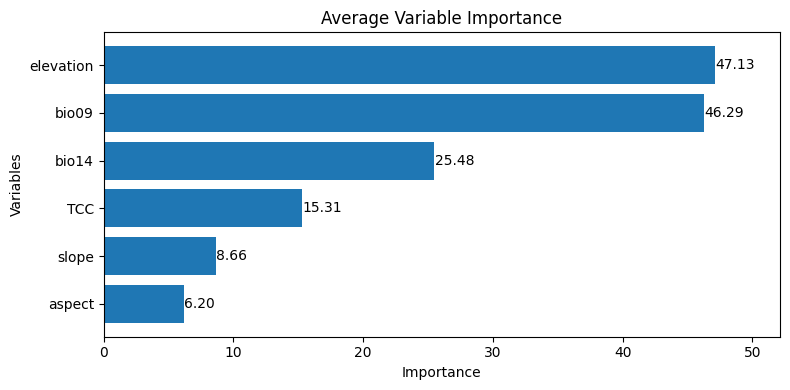

In [43]:
plot_variable_importance(importances_list)

Using the Testing Datasets, we calculate AUC-ROC and AUC-PR for each run. Then, we compute the average AUC-ROC and AUC-PR over n iterations.

**AUC-ROC** represents the area under the curve of the 'Sensitivity (Recall) vs. 1-Specificity' graph, illustrating the relationship between sensitivity and specificity as the threshold changes. Specificity is based on all observed non-occurrences. Therefore, AUC-ROC encompasses all quadrants of the confusion matrix.

**AUC-PR** represents the area under the curve of the 'Precision vs. Recall (Sensitivity)' graph, showing the relationship between precision and recall as the threshold varies. Precision is based on all predicted occurrences. Hence, AUC-PR does not include the true negatives (TN).

> Note: It's important to ensure that each run has a sufficient number of points for model validation. The final number of points may vary due to the random partitioning of spatial blocks, so it's crucial to verify if there are enough presence and pseudo-absence points for model validation. In the case of endangered or rare species, there might be a shortage of occurrence data, leading to an insufficient test dataset. In such cases, alternatives may include additional data collection based on expert knowledge and experience or utilizing relevant alternative data sources.

In [44]:
def print_pres_abs_sizes(TestingDatasets, numiter):
    # Check and print the sizes of presence and pseudo-absence coordinates
    def get_pres_abs_size(x):
        fc = ee.FeatureCollection(TestingDatasets.get(x))
        presence_size = fc.filter(ee.Filter.eq("PresAbs", 1)).size()
        pseudo_absence_size = fc.filter(ee.Filter.eq("PresAbs", 0)).size()
        return ee.List([presence_size, pseudo_absence_size])

    sizes_info = (
        ee.List.sequence(0, ee.Number(numiter).subtract(1), 1)
        .map(get_pres_abs_size)
        .getInfo()
    )

    for i, sizes in enumerate(sizes_info):
        presence_size = sizes[0]
        pseudo_absence_size = sizes[1]
        print(
            f"Iteration {i + 1}: Presence Size = {presence_size}, Pseudo-absence Size = {pseudo_absence_size}"
        )

In [45]:
# Extracting the Testing Datasets
testing_datasets = ee.List.sequence(
    3, ee.Number(numiter).multiply(4).subtract(1), 4
).map(lambda x: results.get(x))

print_pres_abs_sizes(testing_datasets, numiter)

Iteration 1: Presence Size = 13, Pseudo-absence Size = 13
Iteration 2: Presence Size = 50, Pseudo-absence Size = 43
Iteration 3: Presence Size = 19, Pseudo-absence Size = 19
Iteration 4: Presence Size = 42, Pseudo-absence Size = 32
Iteration 5: Presence Size = 57, Pseudo-absence Size = 33
Iteration 6: Presence Size = 42, Pseudo-absence Size = 42
Iteration 7: Presence Size = 46, Pseudo-absence Size = 39
Iteration 8: Presence Size = 45, Pseudo-absence Size = 33
Iteration 9: Presence Size = 39, Pseudo-absence Size = 32
Iteration 10: Presence Size = 48, Pseudo-absence Size = 31


In [46]:
def get_acc(hsm, t_data, grain_size):
    pr_prob_vals = hsm.sampleRegions(
        collection=t_data, properties=["PresAbs"], scale=grain_size
    )
    seq = ee.List.sequence(start=0, end=1, count=25)  # Divide 0 to 1 into 25 intervals

    def calculate_metrics(cutoff):
        # Each element of the seq list is passed as cutoff(threshold value)

        # Observed present = TP + FN
        pres = pr_prob_vals.filterMetadata("PresAbs", "equals", 1)

        # TP (True Positive)
        tp = ee.Number(
            pres.filterMetadata("classification", "greater_than", cutoff).size()
        )

        # TPR (True Positive Rate) = Recall = Sensitivity = TP / (TP + FN) = TP / Observed present
        tpr = tp.divide(pres.size())

        # Observed absent = FP + TN
        abs = pr_prob_vals.filterMetadata("PresAbs", "equals", 0)

        # FN (False Negative)
        fn = ee.Number(
            pres.filterMetadata("classification", "less_than", cutoff).size()
        )

        # TNR (True Negative Rate) = Specificity = TN  / (FP + TN) = TN / Observed absent
        tn = ee.Number(abs.filterMetadata("classification", "less_than", cutoff).size())
        tnr = tn.divide(abs.size())

        # FP (False Positive)
        fp = ee.Number(
            abs.filterMetadata("classification", "greater_than", cutoff).size()
        )

        # FPR (False Positive Rate) = FP / (FP + TN) = FP / Observed absent
        fpr = fp.divide(abs.size())

        # Precision = TP / (TP + FP) = TP / Predicted present
        precision = tp.divide(tp.add(fp))

        # SUMSS = SUM of Sensitivity and Specificity
        sumss = tpr.add(tnr)

        return ee.Feature(
            None,
            {
                "cutoff": cutoff,
                "TP": tp,
                "TN": tn,
                "FP": fp,
                "FN": fn,
                "TPR": tpr,
                "TNR": tnr,
                "FPR": fpr,
                "Precision": precision,
                "SUMSS": sumss,
            },
        )

    return ee.FeatureCollection(seq.map(calculate_metrics))

In [47]:
def calculate_and_print_auc_metrics(images, testing_datasets, grain_size, numiter):
    # Calculate AUC-ROC and AUC-PR
    def calculate_auc_metrics(x):
        hsm = ee.Image(images.get(x))
        t_data = ee.FeatureCollection(testing_datasets.get(x))
        acc = get_acc(hsm, t_data, grain_size)

        # Calculate AUC-ROC
        x = ee.Array(acc.aggregate_array("FPR"))
        y = ee.Array(acc.aggregate_array("TPR"))
        x1 = x.slice(0, 1).subtract(x.slice(0, 0, -1))
        y1 = y.slice(0, 1).add(y.slice(0, 0, -1))
        auc_roc = x1.multiply(y1).multiply(0.5).reduce("sum", [0]).abs().toList().get(0)

        # Calculate AUC-PR
        x = ee.Array(acc.aggregate_array("TPR"))
        y = ee.Array(acc.aggregate_array("Precision"))
        x1 = x.slice(0, 1).subtract(x.slice(0, 0, -1))
        y1 = y.slice(0, 1).add(y.slice(0, 0, -1))
        auc_pr = x1.multiply(y1).multiply(0.5).reduce("sum", [0]).abs().toList().get(0)

        return (auc_roc, auc_pr)

    auc_metrics = (
        ee.List.sequence(0, ee.Number(numiter).subtract(1), 1)
        .map(calculate_auc_metrics)
        .getInfo()
    )

    # Print AUC-ROC and AUC-PR for each iteration
    df = pd.DataFrame(auc_metrics, columns=["AUC-ROC", "AUC-PR"])
    df.index = [f"Iteration {i + 1}" for i in range(len(df))]
    df.to_csv("auc_metrics.csv", index_label="Iteration")
    print(df)

    # Calculate mean and standard deviation of AUC-ROC and AUC-PR
    mean_auc_roc, std_auc_roc = df["AUC-ROC"].mean(), df["AUC-ROC"].std()
    mean_auc_pr, std_auc_pr = df["AUC-PR"].mean(), df["AUC-PR"].std()
    print(f"Mean AUC-ROC = {mean_auc_roc:.4f} ± {std_auc_roc:.4f}")
    print(f"Mean AUC-PR = {mean_auc_pr:.4f} ± {std_auc_pr:.4f}")

In [48]:
%%time

# Calculate AUC-ROC and AUC-PR
calculate_and_print_auc_metrics(images, testing_datasets, grain_size, numiter)

               AUC-ROC    AUC-PR
Iteration 1   0.816239  0.718313
Iteration 2   0.783889  0.824005
Iteration 3   0.637427  0.663028
Iteration 4   0.674831  0.657674
Iteration 5   0.908485  0.822591
Iteration 6   0.766071  0.720562
Iteration 7   0.795151  0.858168
Iteration 8   0.828409  0.849845
Iteration 9   0.812500  0.847266
Iteration 10  0.832708  0.854010
Mean AUC-ROC = 0.7856 ± 0.0785
Mean AUC-PR = 0.7815 ± 0.0821
CPU times: user 1.36 s, sys: 185 ms, total: 1.55 s
Wall time: 4min 5s


This tutorial has provided a practical example of using Google Earth Engine (GEE) for Species Distribution Modeling (SDM). An important takeaway is the versatility and flexibility of GEE in the field of SDM. Leveraging Earth Engine's powerful geospatial data processing capabilities opens up endless possibilities for researchers and conservationists to understand and preserve biodiversity on our planet. By applying the knowledge and skills gained from this tutorial, individuals can explore and contribute to this fascinating field of ecological research.